In [1]:
cd ..

/home/luco/python/ml-imdb


In [2]:
%matplotlib inline
import json
import numpy as np
import seaborn as sb

# Movie Rating Prediction

### We are going to predict average movies' ratings by looking at actors, directors and genres.

Note: Actors, actresses and directors are smashed into a single list in the dataset

## Parameters

In [3]:
TRAIN_RANGE = (1990, 2000)  # release years
TEST_RANGE = (2000, 2005)  # release years
MIN_ACTOR_FREQ = 10

Here we have some parameters

- extending lower bound of train set ===> training on far history ===> worse results
- too low min. actor freq. (e.g. < 5) ===> data sparsity, noise ===> worse results

## Load Movies

In [4]:
with open("./movie-dict-1970-2005.json") as f:
    json_data = json.load(f)

In [5]:
movies = [
    (movie_name, movie_data)
    for movie_name, movie_data
    in json_data["data"].items()
    if "actors" in movie_data and
    movie_data["year"] >= TRAIN_RANGE[0]
]

In [6]:
len(movies)

53302

In [7]:
movies[0]

(u'Country (2000)',
 {u'actors': [[u'Liddy, Kevin (I)', 0],
   [u'Harrow, Lisa', u'1'],
   [u'Cave, Des', u'2'],
   [u'Lydon, Gary', u'3'],
   [u'Plunkett, Marcella', u'4']],
  u'btw': 0.0,
  u'genres': [u'Drama'],
  u'rating': 7.3,
  u'votes': 42,
  u'year': 2000})

## Analysis of Actors

In [8]:
set_of_actors = set(
    actor
    for _, movie_data in movies
    for actor, _ in movie_data["actors"]
)

actor_freq = {actor: 0 for actor in set_of_actors}

for _, movie_data in movies:
    for actor, _ in movie_data["actors"]:
        actor_freq[actor] += 1

In [9]:
len(set_of_actors)

78972

### Actor Freq Histogram

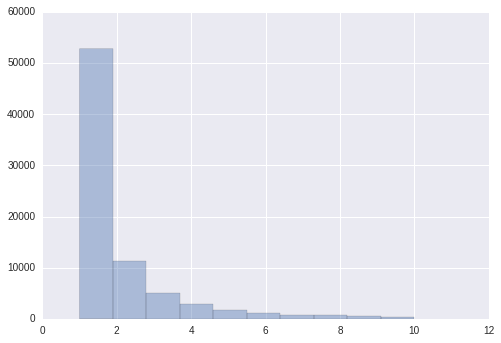

In [10]:
sb.distplot(
    [freq for _, freq in actor_freq.items()
     if freq < 11],
    kde=False, bins=10
)

### The vast majority of actors occur just in a single movie.  That's called the data sparsity problem.

## Gettin' Rid of Data Sparsity

Let's filter out actors occuring infrequently:

In [11]:
actors = {actor for actor, freq in actor_freq.items() if freq >= MIN_ACTOR_FREQ}

In [12]:
len(actors)

2188

Now we need to filter out movies that do not contain any of the "restricted" actors.

In [13]:
for _, movie_data in movies:
    movie_data["actors"] = {
        actor for actor, __ in movie_data["actors"]
        if actor in actors
    }

movies = [
    (movie_name, movie_data)
    for movie_name, movie_data
    in movies if len(movie_data["actors"]) > 0
]

movies.sort(key=lambda (_, md): md["year"])

In [14]:
len(movies)

20257

## Release Year Histogram

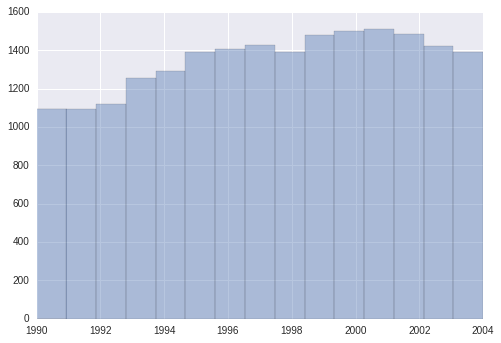

In [15]:
sb.distplot(
    [movie_data["year"] for _, movie_data in movies],
    kde=False, bins=15
)

## Baking Data

In [16]:
genres = set(
    genre
    for _, movie_data in movies
    for genre in movie_data["genres"]
)
len(genres)

26

In [17]:
actor2i = {actor: i for i, actor in enumerate(sorted(actors))}
genre2i = {genre: i for i, genre in enumerate(sorted(genres))}

### Vectorizing

In [18]:
data_x = np.zeros(shape=(len(movies), len(actors) + len(genres)), dtype=np.float32)  
data_y = np.zeros(shape=(len(movies),1))

for movie_index, (movie_name, movie_data)  in enumerate(movies):
    
    for actor in movie_data["actors"]:
        data_x[movie_index, actor2i[actor]] = 1

    for genre in movie_data["genres"]:
        data_x[movie_index, len(actors) + genre2i[genre]] = 1 

    data_y[movie_index,0] = movie_data["rating"]

In [19]:
threshold = min(i for i, (_, movie_data) in enumerate(movies) if movie_data["year"] == 2000)
threshold

12950

## Data for Training / Testing

We divide the data into 2 parts - movies are sorted chronologically, so we will test models 

In [20]:
x_train = data_x[:threshold,:]
x_test = data_x[threshold:,:]

y_train = data_y[:threshold]
y_test = data_y[threshold:]

In [21]:
x_train.shape, y_train.shape

((12950, 2214), (12950, 1))

# Models

In [22]:
from sklearn.svm import LinearSVR
from sklearn.metrics import mean_squared_error, mean_absolute_error

from keras.models import Sequential
from keras.layers import Input, Dense, Dropout
from keras.activations import relu
from keras.optimizers import SGD

Using TensorFlow backend.


## Baseline - Average Rating

We use a simple baseline - compute the average average rating of movies in the train set ...

In [23]:
avg_rating = np.average(y_train)
avg_rating

6.1392046332046339

...  and use that value as a prediction for every single movie from the test set.

In [24]:
avg_arr = np.full(shape=(len(y_test),), fill_value=avg_rating)

In [25]:
mean_squared_error(avg_arr, y_test[:,0])

1.8748920498086437

In [26]:
mean_absolute_error(avg_arr, y_test[:,0])

1.0819370678034972

#### Absolute Error Distribution

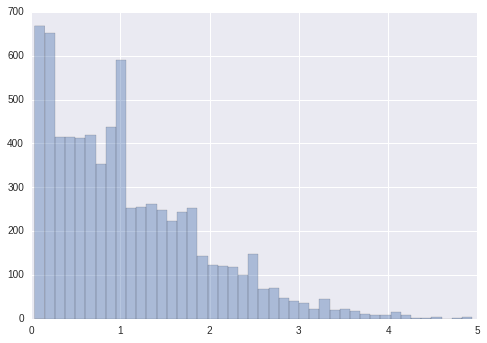

In [27]:
sb.distplot(np.abs(y_test[:,0] - avg_rating), kde=False)

## Support Vector Regression

Kernelized SVR took forever to train, so we use only linear SVR here.

In [28]:
model = LinearSVR()

In [29]:
model.fit(x_train, y_train[:,0])

LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=None, tol=0.0001, verbose=0)

In [30]:
mean_squared_error(model.predict(x_test), y_test[:,0])

1.4471916162214098

In [31]:
mean_absolute_error(model.predict(x_test), y_test[:,0])

0.92739608282540231

#### Absolute Error Distribution

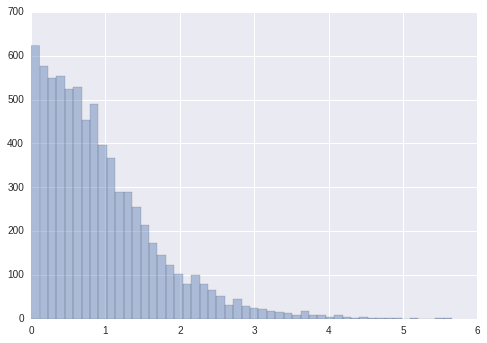

In [32]:
sb.distplot(np.abs(y_test[:,0] - model.predict(x_test)), kde=False)

In [33]:
del model  # to release memory

## Feedforward Neural Network

In [34]:
model = Sequential()

input_shape = (data_x.shape[1], )

model.add(Dense(160, activation=relu, input_shape=input_shape))
model.add(Dropout(0.4))
model.add(Dense(160, activation=relu))
model.add(Dropout(0.4))
model.add(Dense(1, activation=relu))

In [35]:
model.compile(loss="mse", metrics=["mae"], optimizer="adadelta")

In [36]:
model.fit(x_train, y_train,
          validation_data=(x_test, y_test),
          epochs=25, batch_size=500, verbose=1)

Train on 12950 samples, validate on 7307 samples
Epoch 1/25
12950/12950 [==============================] - 1s - loss: 10.3711 - mean_absolute_error: 2.4880 - val_loss: 1.8753 - val_mean_absolute_error: 1.0807
Epoch 2/25
12950/12950 [==============================] - 1s - loss: 1.8268 - mean_absolute_error: 1.0770 - val_loss: 1.8626 - val_mean_absolute_error: 1.0896
Epoch 3/25
12950/12950 [==============================] - 1s - loss: 1.6199 - mean_absolute_error: 1.0071 - val_loss: 1.8153 - val_mean_absolute_error: 1.0589
Epoch 4/25
12950/12950 [==============================] - 1s - loss: 1.5490 - mean_absolute_error: 0.9815 - val_loss: 1.7145 - val_mean_absolute_error: 1.0284
Epoch 5/25
12950/12950 [==============================] - 1s - loss: 1.4609 - mean_absolute_error: 0.9501 - val_loss: 1.6370 - val_mean_absolute_error: 0.9990
Epoch 6/25
12950/12950 [==============================] - 1s - loss: 1.4054 - mean_absolute_error: 0.9284 - val_loss: 1.6061 - val_mean_absolute_error: 0.9

#### Absolute Error Distribution

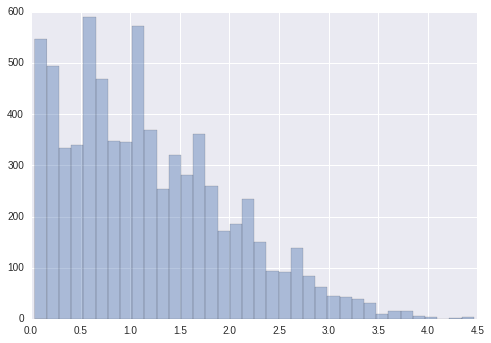

In [42]:
sb.distplot(np.abs(y_test[:,0] - model.predict(x_test)[0]), kde=False)